In [1]:
# Способы борьбы с мультиколлинеарностью: Ridge, LASSO, PCA

import pandas as pd # работа с таблицами 
import numpy as np # математические функции и матрицы
import matplotlib.pyplot as plt # графики
import seaborn as sns # еще более классные графики
import statsmodels.api as sm # стандартные регрессионные модели
import statsmodels.formula.api as smf # аналогичные модели с синтаксисом в стиле R
import statsmodels.graphics.gofplots as gf # визуализация моделей
from statsmodels.stats.outliers_influence import summary_table # работа с выбросами
from scipy.stats import shapiro # тест Шапиро – Уилка 
from sklearn.decomposition import PCA # функция PCA, вычисляющая главные компоненты
from sklearn.preprocessing import StandardScaler # стандартизация признаков
from sklearn.linear_model import ElasticNetCV, ElasticNet # Ridge, LASSO

In [2]:
get_ipython().system('pip install rdatasets') # наборы данных
# !pip install pyreadstat # чтение spss/stata данных
from rdatasets import data 
# from pyreadstat import read_sav, set_value_labels

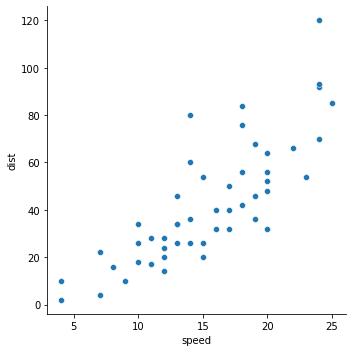

In [3]:
# LASSO
cars = data('cars')
sns.relplot(data=cars, x='speed', y='dist')

In [4]:
# Предположив по графику присутствие нелинейной зависимости между dist и speed, добавим новые переменнеы
cars['speed2'] = cars['speed'] ** 2
cars['speed3'] = cars['speed'] ** 3

# Определим зависимую переменную в вектор y, а объясняющие переменные - в матрицу X
y = cars['dist']
X = cars[['speed', 'speed2', 'speed3']]

X.head()

,speed,speed2,speed3
0,4,16,64
1,4,16,64
2,7,49,343
3,7,49,343
4,8,64,512


In [5]:
# Стандартизируем объясняющие переменные (среднее = 0, стандартное отклонение = 1)
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-2.17785805, -1.53990046, -1.15654711],
       [-2.17785805, -1.53990046, -1.15654711],
       [-1.60473751, -1.335456  , -1.08984806],
       [-1.60473751, -1.335456  , -1.08984806],
       [-1.41369733, -1.2425267 , -1.04944613],
       [-1.22265715, -1.13720683, -0.9975691 ],
       [-1.03161697, -1.01949638, -0.93278257],
       [-1.03161697, -1.01949638, -0.93278257],
       [-1.03161697, -1.01949638, -0.93278257],
       [-0.84057679, -0.88939536, -0.85365216],
       [-0.84057679, -0.88939536, -0.85365216],
       [-0.64953661, -0.74690376, -0.75874348],
       [-0.64953661, -0.74690376, -0.75874348],
       [-0.64953661, -0.74690376, -0.75874348],
       [-0.64953661, -0.74690376, -0.75874348],
       [-0.45849643, -0.5920216 , -0.64662215],
       [-0.45849643, -0.5920216 , -0.64662215],
       [-0.45849643, -0.5920216 , -0.64662215],
       [-0.45849643, -0.5920216 , -0.64662215],
       [-0.26745625, -0.42474886, -0.51585377],
       [-0.26745625, -0.42474886, -0.515

In [6]:
from sklearn import preprocessing
y_scale = preprocessing.scale(y)
y_scale

array([-1.60640478, -1.29280697, -1.52800533, -0.82241026, -1.05760862,
       -1.29280697, -0.97920916, -0.66561135, -0.35201354, -1.01840889,
       -0.5872119 , -1.13600807, -0.90080971, -0.74401081, -0.5872119 ,
       -0.66561135, -0.35201354, -0.35201354,  0.11838317, -0.66561135,
       -0.27361409,  0.66717934,  1.45117387, -0.90080971, -0.66561135,
        0.43198098, -0.43041299, -0.11681518, -0.43041299, -0.11681518,
        0.27518208, -0.03841573,  0.51038044,  1.29437496,  1.60797277,
       -0.27361409,  0.11838317,  0.98077715, -0.43041299,  0.19678263,
        0.35358153,  0.51038044,  0.82397825,  0.9023777 ,  0.43198098,
        1.0591766 ,  1.92157058,  1.96077031,  3.01916292,  1.6471725 ])

In [7]:
# Оценим LASSO при lambda (alpha) = 0.01
model = ElasticNet(alpha=0.01, l1_ratio=1, normalize=True).fit(X_scaled, y)

In [8]:
model.alpha

0.01

In [9]:
model.coef_

array([11.04051453,  0.        , 10.08815807])

In [10]:
model.intercept_

42.98

In [11]:
# Теперь посмотрим как изменятся оценки коэффициентов, перебирая разные lambda (alpha)
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
models = [ElasticNet(alpha, l1_ratio=1, normalize=True, max_iter = 100000).fit(X, y) for alpha in alphas]

In [12]:
betas_hat = [model.coef_ for model in models]
betas_hat

[array([ 6.63176454, -0.33702182,  0.0099689 ]),
 array([ 5.10891851, -0.22338872,  0.0074226 ]),
 array([2.10918188, 0.        , 0.00241172]),
 array([2.04664289, 0.        , 0.00233306]),
 array([0.2364628 , 0.07765045, 0.        ])]

In [13]:
r2s = [model.score(X, y) for model in models]
r2s

[0.673176305773955,
 0.67272744274045,
 0.6696966410371289,
 0.6689112017683259,
 0.5897163312914576]

In [49]:
# А теперь попробуем определить оптимальное значение для lambda (alpha), перебирая ее значения от 0.000001 до 1 с шагом 0.01,
# используя алгоритм кросс-валидации (разобъем нашу выборку на 10 равнхы подвыборок, то есть cv=10)
more_alphas = np.arange(0.000001, 1, 0.01)
fit_lr = ElasticNetCV(l1_ratio=1, alphas=more_alphas, normalize=True, cv=10, random_state=777, max_iter=10000000).fit(X, y)
print(fit_lr.alpha_)

0.030001


In [50]:
# Оценим LASSO при оптимальном значении lambda(alpha)=0.030001
lasso_best = ElasticNet(alpha=fit_lr.alpha_, l1_ratio=1, normalize=True).fit(X, y)
print(lasso_best.coef_) # выведем оценки коэффициентом модели
print(lasso_best.intercept_) # а также оценку константы в модели

[2.09541032 0.         0.00239409]
-1.0246825647625357


In [51]:
# Построим прогноз по модели для двух новых наблюдений speed = 10 и speed = 20
new = [[10, 100, 1000], [20, 400, 8000]]
lasso_best.predict(new)

array([22.32351337, 60.03626548])

In [28]:
# Теперь перейдем к Ridge-регрессии
# Оценим ридж-регрессию для lambda(alpha)=0.1
model_rr = ElasticNet(alpha=0.1, l1_ratio=0, normalize=True, max_iter = 100000).fit(X, y)

In [29]:
model_rr.coef_

array([0.49649061, 0.01623067, 0.0006174 ])

In [31]:
model_rr.intercept_

28.01367531553091

In [48]:
more_alphas = np.arange(0.01, 1, 0.01)
fit_rr = ElasticNetCV(l1_ratio=0, alphas=more_alphas, normalize=True, cv=10, max_iter=10000000).fit(X, y)
print(fit.alpha_)

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12756.250581961454, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alp

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12667.267967837246, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12660.639471087567, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12539.597477210647, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12340.9994374037, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12324.858987186719, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11989.635135550878, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11958.479768340982, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11024.881101521574, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10926.224533021626, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7135.960095953619, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6330.716947447001, tolerance: 2.6509111111111117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14086.489493395373, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14079.157331166618, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13946.176403253205, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13935.432610220732, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13748.342047172626, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13731.665938530246, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13362.951073093061, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13330.903431592367, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12580.45121230638, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12501.327949862025, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10164.111128414683, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9797.064021440518, tolerance: 2.951497777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14404.162917053125, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14397.214471500616, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14252.012650232424, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14241.488134536525, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14059.351201135465, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14043.220145437252, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13719.786850739138, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13690.808795460178, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12897.8141763654, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12821.72844968929, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10329.934299994184, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9951.53871559372, tolerance: 3.013577777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coo

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15156.516307191981, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15149.131203991508, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14984.037028664869, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14972.617404227694, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14701.458337781216, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14272.166173410411, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14234.610664643267, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13432.399068301725, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13343.877216589277, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9839.214828823842, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9266.53566119469, tolerance: 3.1738800000000005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14229.107059003638, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14220.798152357109, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14046.326741536574, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14033.618069471422, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13729.320281784881, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13706.733455153915, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13193.784650423648, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13147.940234433738, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12129.108076687085, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12011.844331161723, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5256.7067476410975, tolerance: 3.001257777777778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15395.395508435118, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15264.686353215257, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14979.914588522071, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14962.928998244119, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14595.977561157117, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14564.84178002461, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13933.990627560768, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13868.157711627267, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11732.16209503827, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11452.611941927998, tolerance: 3.2152311111111116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14002.534347979321, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alp

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13863.651873501312, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13853.678807348242, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13668.109604879408, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13652.718021052608, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13348.749122890134, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13321.93919685001, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12733.483930498282, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12675.537111167772, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11408.687065006356, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11241.403215127224, tolerance: 2.9353644444444447
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15139.509324169047, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15132.558434901175, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14979.318448426455, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14968.86855043059, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14690.781289348995, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672.206991558414, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14157.133330855415, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14117.274684761347, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13265.823129150936, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13171.862646432204, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9962.047600750015, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9450.970157575794, tolerance: 3.170431111111111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coo

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14821.98579380176, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alph

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14612.524962372083, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14600.025112821462, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14361.255477316596, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14340.908990328386, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13920.843299673686, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13882.044882495316, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12948.830996211449, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12847.596992134253, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9583.446051097724, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9017.559632390228, tolerance: 3.1062800000000004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8619.731538742504, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8616.317704100507, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8559.394387929751, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8554.541731650745, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8455.44562593729, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8447.512490881634, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8224.182745339596, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8206.627211041028, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7679.774794940488, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7624.008272039126, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5460.567647548565, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(


0.030001


/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4985.239269561084, tolerance: 1.7871200000000003
  model = cd_fast.enet_coordinate_descent_gram(


In [46]:
fit_rr.alpha_

0.01

In [43]:
fit_rr.coef_

array([1.16714267, 0.03714321, 0.00141254])

In [44]:
fit_rr.intercept_

8.255409635104073

In [ ]:
# Метод главных компонент (Principal Component Analysis)

data = pd.read_excel('/Users/polinapogorelova/Desktop/Метрика_ИП/Данные/dataflats.xlsx')

In [ ]:
data.head()

In [97]:
data['price_sq'] = data['price']/data['totsp']
data

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,factor,price_sq
0,81,58,40,6.0,12.5,7,1,1,1,кирпич,1.396552
1,75,44,28,6.0,13.5,7,1,0,1,не кирпич,1.704545
2,128,70,42,6.0,14.5,3,1,1,1,кирпич,1.828571
3,95,61,37,6.0,13.5,7,1,0,1,не кирпич,1.557377
4,330,104,60,11.0,10.5,7,0,1,1,кирпич,3.173077
...,...,...,...,...,...,...,...,...,...,...,...
2035,110,77,45,10.0,12.0,5,0,0,1,не кирпич,1.428571
2036,95,60,43,6.0,9.0,5,0,0,1,не кирпич,1.583333
2037,95,60,46,5.0,10.5,5,1,0,1,не кирпич,1.583333
2038,129,76,48,10.0,12.5,5,0,0,1,не кирпич,1.697368


In [98]:
features = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist'] # добавляем количественные регрессоры в отдельный список
x = data[features] # отбираем признаки
y = data['price_sq'] # выделяем целевую переменную
x_scaled = StandardScaler().fit_transform(x) # стандартизируем регрессоры

In [99]:
y

0       1.396552
1       1.704545
2       1.828571
3       1.557377
4       3.173077
          ...   
2035    1.428571
2036    1.583333
2037    1.583333
2038    1.697368
2039    1.609375
Name: price_sq, Length: 2040, dtype: float64

In [100]:
x_scaled

array([[-0.99765678, -0.80295532, -1.040579  ,  0.4398343 , -0.29286045],
       [-1.92359847, -2.3234029 , -1.040579  ,  0.73615595, -0.29286045],
       [-0.20399248, -0.54954739, -1.040579  ,  1.03247761, -1.34145247],
       ...,
       [-0.8653794 , -0.04273153, -1.39952069, -0.15280901, -0.81715646],
       [ 0.19283968,  0.2106764 ,  0.39518776,  0.4398343 , -0.81715646],
       [-0.60082463, -0.1694355 , -0.68163731,  1.32879926, -0.81715646]])

In [101]:
pca_model = PCA(n_components=5) # создаем 6 главныx компонент
principalComponents = pca_model.fit_transform(x_scaled)
principaldata = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']) # создаем таблицу, в которую сохраняем значения найденных компонент
principaldata

,PC1,PC2,PC3,PC4,PC5
0,-1.664595,-0.170182,-0.382594,-0.235535,-0.019761
1,-3.132676,-0.058395,-0.619063,0.778132,0.055991
2,-1.065828,-0.464760,-1.553843,-0.575355,0.440988
3,-1.802300,0.046424,-0.623437,-0.065274,0.324892
4,2.665792,-0.010419,-0.201316,-0.725857,0.426100
...,...,...,...,...,...
2035,0.275382,-0.316997,-0.834723,0.330752,0.149290
2036,-1.189425,-1.227353,0.013890,-0.328122,-0.077456
2037,-1.229762,-0.987383,-0.245725,-0.906326,-0.177236
2038,0.429200,-0.226317,-0.919538,0.076687,-0.109912


In [102]:
principalComponents

array([[-1.66459452, -0.17018166, -0.38259433, -0.23553509, -0.01976062],
       [-3.13267558, -0.05839455, -0.6190627 ,  0.77813226,  0.05599062],
       [-1.06582774, -0.4647602 , -1.55384348, -0.57535536,  0.4409881 ],
       ...,
       [-1.22976237, -0.98738285, -0.24572519, -0.9063262 , -0.17723567],
       [ 0.42919957, -0.22631679, -0.91953842,  0.07668686, -0.10991179],
       [-0.97219257,  0.12719381, -1.41041236, -0.54458839, -0.20150438]])

In [103]:
principaldata['price_sq'] = y
principaldata['walk'] = data['walk']
principaldata

,PC1,PC2,PC3,PC4,PC5,price_sq,walk
0,-1.664595,-0.170182,-0.382594,-0.235535,-0.019761,1.396552,1
1,-3.132676,-0.058395,-0.619063,0.778132,0.055991,1.704545,1
2,-1.065828,-0.464760,-1.553843,-0.575355,0.440988,1.828571,1
3,-1.802300,0.046424,-0.623437,-0.065274,0.324892,1.557377,1
4,2.665792,-0.010419,-0.201316,-0.725857,0.426100,3.173077,0
...,...,...,...,...,...,...,...
2035,0.275382,-0.316997,-0.834723,0.330752,0.149290,1.428571,0
2036,-1.189425,-1.227353,0.013890,-0.328122,-0.077456,1.583333,0
2037,-1.229762,-0.987383,-0.245725,-0.906326,-0.177236,1.583333,1
2038,0.429200,-0.226317,-0.919538,0.076687,-0.109912,1.697368,0


In [73]:
pca.explained_variance_ratio_

array([0.50402812, 0.21584758, 0.18005558, 0.08360339, 0.01646533])

Text(0.5, 0, 'Главные компоненты')

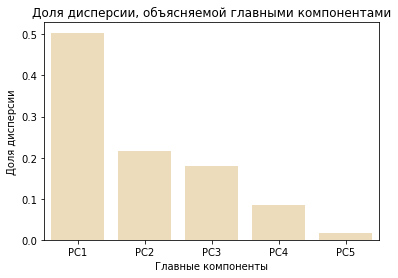

In [74]:
d = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':['PC1', 'PC2', 'PC3','PC4','PC5']})
graph = sns.barplot(x = 'PC', y = 'var', data = d, color = 'wheat')
graph.set_title('Доля дисперсии, объясняемой главными компонентами')
graph.set_ylabel('Доля дисперсии')
graph.set_xlabel('Главные компоненты')

In [104]:
# Оценим регрессию price_sq на главные компоненты
regr = smf.ols('price_sq ~ PC1 + PC2 + PC3 + PC4 + PC5 + walk', data=principaldata).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_sq   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     173.2
Date:                Sun, 20 Nov 2022   Prob (F-statistic):          3.12e-178
Time:                        18:40:57   Log-Likelihood:                -633.77
No. Observations:                2040   AIC:                             1282.
Df Residuals:                    2033   BIC:                             1321.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6220      0.013    122.630      0.000       1.596       1.648
PC1            0.0975      0.005     21.118      0.000       0.088       0.107
PC2           -0.1322      0.007    -18.574      0.000      -0.146      -0.118
PC3            0.0597      0.008      7.688      0.000       0.044       0.075
PC4            0.0149      0.011      1.318      0.188      -0.007       0.037
PC5           -0.1173      0.026     -4.592      0.000      -0.167      -0.067
walk           0.1396      0.016      8.692      0.000       0.108       0.171
==============================================================================
Omnibus:                      833.914   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7507.026
Skew:                           1.678   Prob(JB):                         0.00
Kurtosis:                      11.778   Cond. No.                         5.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""